In [2]:
import numpy as np

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, ScaledArgFunction \

# Import CIL Processors for preprocessing
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter

# Import CIL utilities
from cil.utilities.display import show2D
from cil.utilities import dataexample

# Import from CIL ASTRA plugin
from cil.plugins.tigre import ProjectionOperator


# Import FBP from CIL recon class
from cil.recon import FBP, FDK

from cil.framework import ImageData

#Import Total Variation from the regularisation toolkit plugin
from cil.plugins.ccpi_regularisation.functions import FGP_TV

# All external imports
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

FDK recon

Input Data:
	angle: 60
	vertical: 128
	horizontal: 128

Reconstruction Volume:
	vertical: 128
	horizontal_y: 128
	horizontal_x: 128

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 8
	Filter_inplace: False



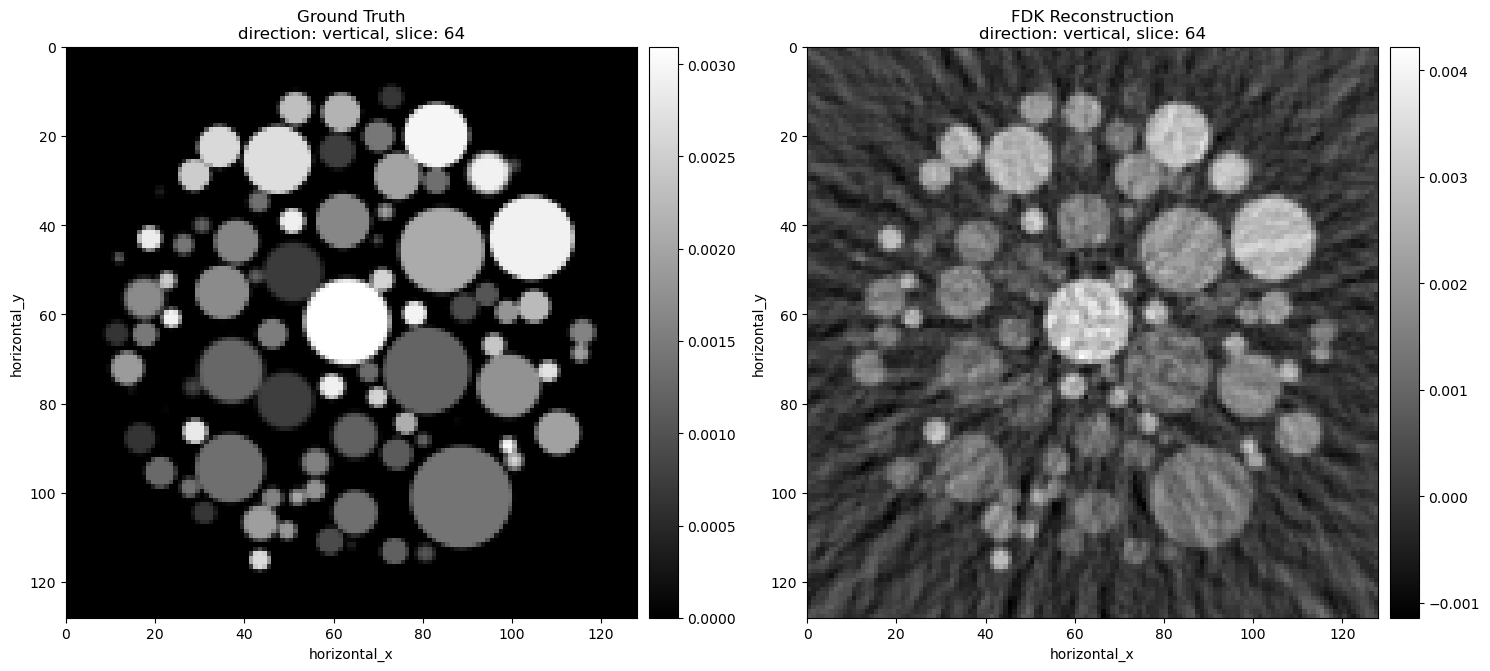

In [3]:
ground_truth = dataexample.SIMULATED_SPHERE_VOLUME.get()

data = dataexample.SIMULATED_CONE_BEAM_DATA.get()


absorption = TransmissionAbsorptionConverter()(data)
absorption = Slicer(roi={'angle':(0, -1, 5)})(absorption)

ig = ground_truth.geometry

recon = FDK(absorption, image_geometry=ig).run()
show2D([ground_truth, recon], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

In [4]:
A = ProjectionOperator(ig, absorption.geometry, device = "gpu")

#  PDHG with implicit TV regularisation

In [8]:
F = 0.5 * L2NormSquared(b=absorption)
alpha = 0.5
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0

gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/A.norm()
    tau =(rho/gamma)/A.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = A,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)
    

gamma =  0.01


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  0.1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1000


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  2.0


  0%|          | 0/200 [00:00<?, ?it/s]

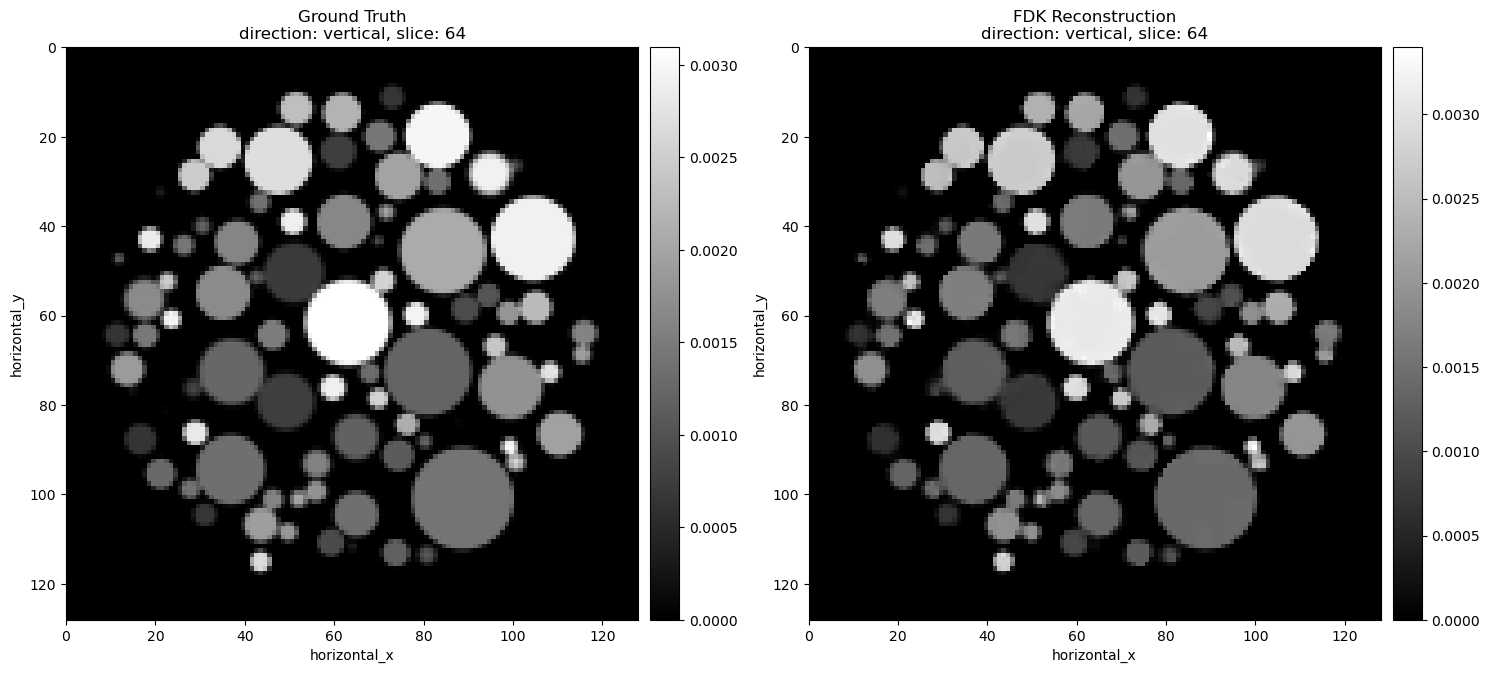

In [9]:
show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

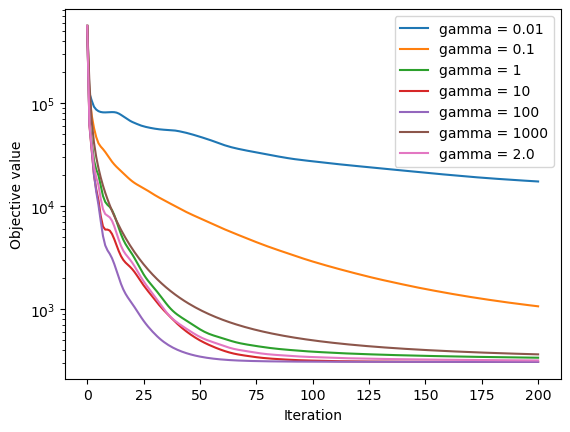

In [10]:
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.show()

In [11]:
print( F(A.direct(pdhg_tv_explicit.solution)) )
print( G(pdhg_tv_explicit.solution) )


92.56171417236328
223.63340759277344


In [12]:
best_gamma_list=[0]*5
alpha_list = [0.1, 0.5, 1, 2, 5]
for i, alpha in enumerate(alpha_list):
    print("alpha = ", alpha)
    objective = 1e10
    F = 0.5 * L2NormSquared(b=absorption)
    G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
    rho = 1.0

    gamma_list = [1,5,10,50,100,500,1000]
    results_vanilla = []
    objective_vanilla = []
    for gamma in gamma_list:
        print("gamma = ", gamma)
        sigma = gamma*rho/A.norm()
        tau =(rho/gamma)/A.norm() 
        pdhg_tv_explicit = PDHG(f = F, g = G, operator = A,
                    update_objective_interval = 200, check_convergence=False, sigma=sigma, tau=tau)
        pdhg_tv_explicit.run(200, verbose=1)
        if pdhg_tv_explicit.objective[-1] < objective:
            objective = pdhg_tv_explicit.objective[-1]
            best_gamma_list[i] = gamma
    

alpha =  0.1
gamma =  1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  5


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  50


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  500


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1000


  0%|          | 0/200 [00:00<?, ?it/s]

alpha =  0.5
gamma =  1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  5


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  50


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  500


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1000


  0%|          | 0/200 [00:00<?, ?it/s]

alpha =  1
gamma =  1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  5


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  50


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  500


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1000


  0%|          | 0/200 [00:00<?, ?it/s]

alpha =  2
gamma =  1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  5


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  50


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  500


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1000


  0%|          | 0/200 [00:00<?, ?it/s]

alpha =  5
gamma =  1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  5


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  50


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  500


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1000


  0%|          | 0/200 [00:00<?, ?it/s]

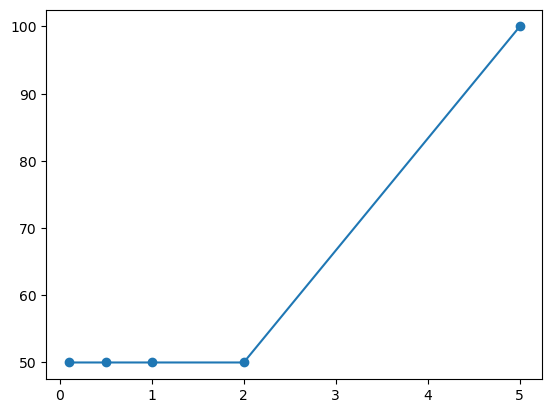

In [13]:
plt.plot(alpha_list, best_gamma_list, marker='o')

In [14]:
F = 0.5 * L2NormSquared(b=absorption)
alpha = 10
G = alpha *  FGP_TV( device='gpu', nonnegativity=True)
rho = 1.0
norm= A.norm()
gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
gamma_list = [norm*gamma for gamma in gamma_list]
results_scaled = []
objective_scaled = []


F_scaled = ScaledArgFunction(F, norm)
A_scaled = (1/norm)*A
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho
    tau =(rho/gamma)
    pdhg_tv_explicit = PDHG(f = F_scaled, g = G, operator = A_scaled,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_scaled.append(pdhg_tv_explicit.solution)
    objective_scaled.append(pdhg_tv_explicit.objective)
    

gamma =  13.70426025390625


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  137.0426025390625


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1370.426025390625


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  13704.26025390625


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  137042.6025390625


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1370426.025390625


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  137.0426025390625


  0%|          | 0/200 [00:00<?, ?it/s]

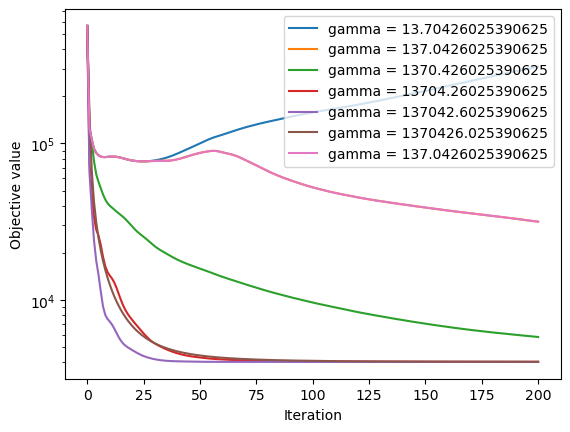

In [15]:
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_scaled[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.show()

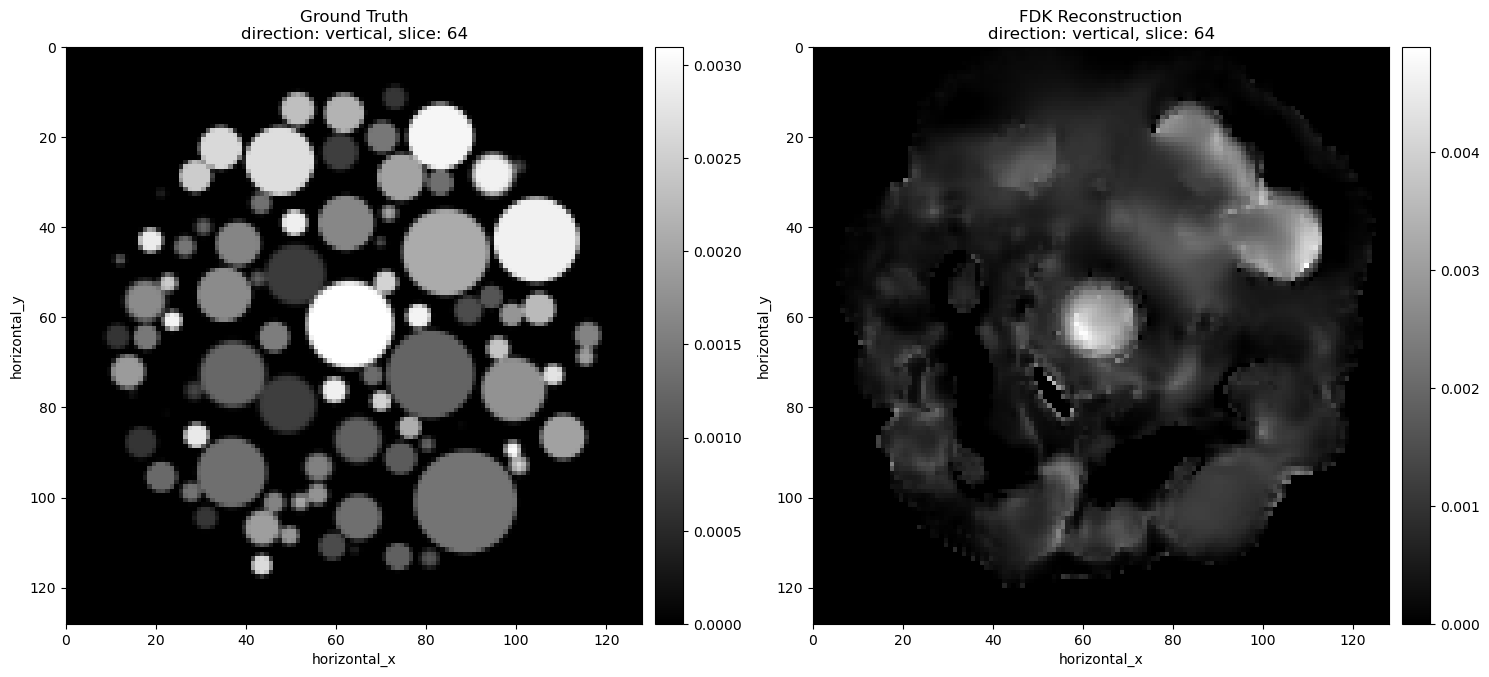

In [16]:
show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

In [17]:
print( F_scaled(A.direct(pdhg_tv_explicit.solution)/norm) )
print( G(pdhg_tv_explicit.solution) )

28551.357421875
3105.835693359375


# PDHG with Explicit TV

In [14]:
# Vanilla TV with reg parameter in front of Mixed L21 Norm
alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  alpha *MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad =  GradientOperator(ig)
K = BlockOperator(Grad, A)



gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/K.norm()
    tau =(rho/gamma)/K.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)



gamma =  0.01


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  0.1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1000


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  2.0


  0%|          | 0/200 [00:00<?, ?it/s]

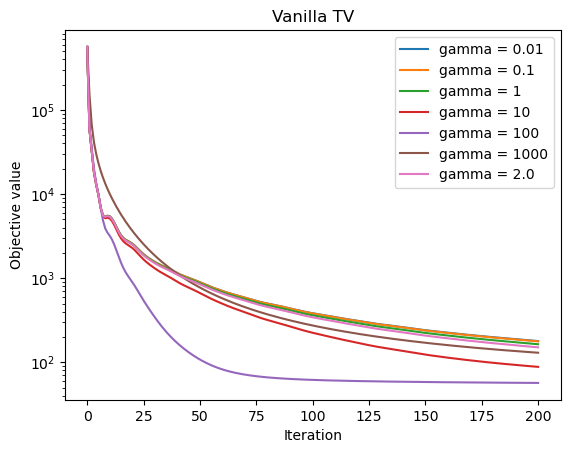

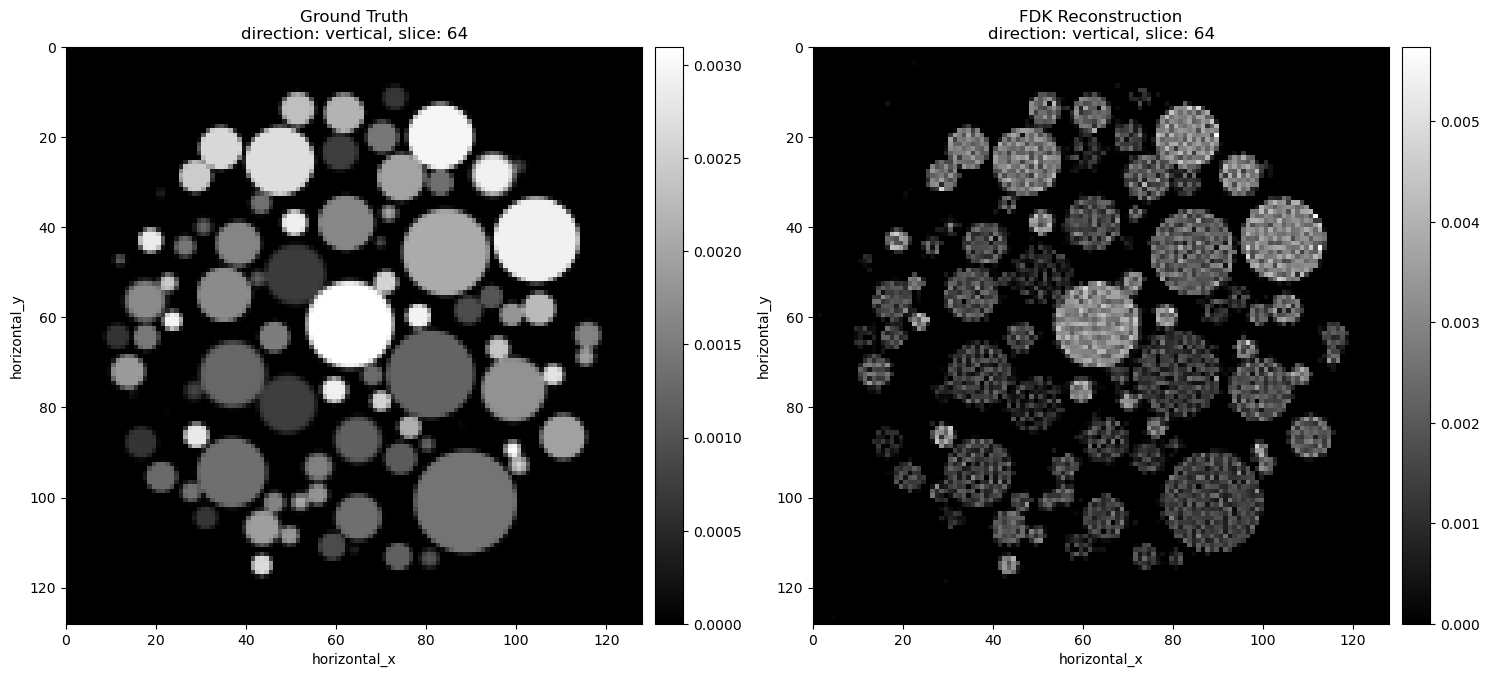

150.50221942542908
0.0


In [15]:

    
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.title('Vanilla TV')
plt.show()

show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

print( F(K.direct(pdhg_tv_explicit.solution)) )
print( G(pdhg_tv_explicit.solution) )


In [7]:
#   Vanilla TV with reg parameter in front of gradient operator

alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 =  MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = alpha * GradientOperator(ig)
K = BlockOperator(Grad, A)



gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
results_vanilla = []
objective_vanilla = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho/K.norm()
    tau =(rho/gamma)/K.norm() 
    pdhg_tv_explicit = PDHG(f = F, g = G, operator = K,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_vanilla.append(pdhg_tv_explicit.solution)
    objective_vanilla.append(pdhg_tv_explicit.objective)
    


gamma =  0.01


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  0.1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1000


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  2.0


  0%|          | 0/200 [00:00<?, ?it/s]

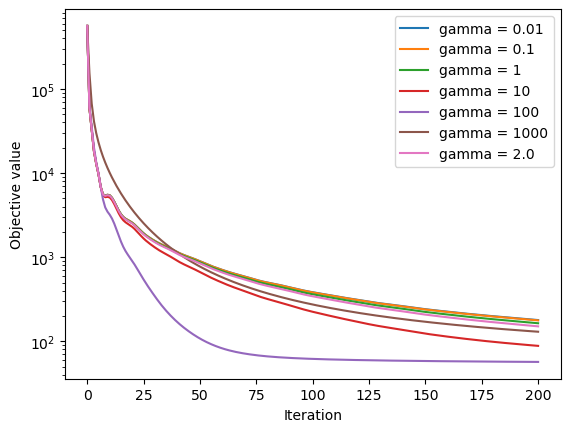

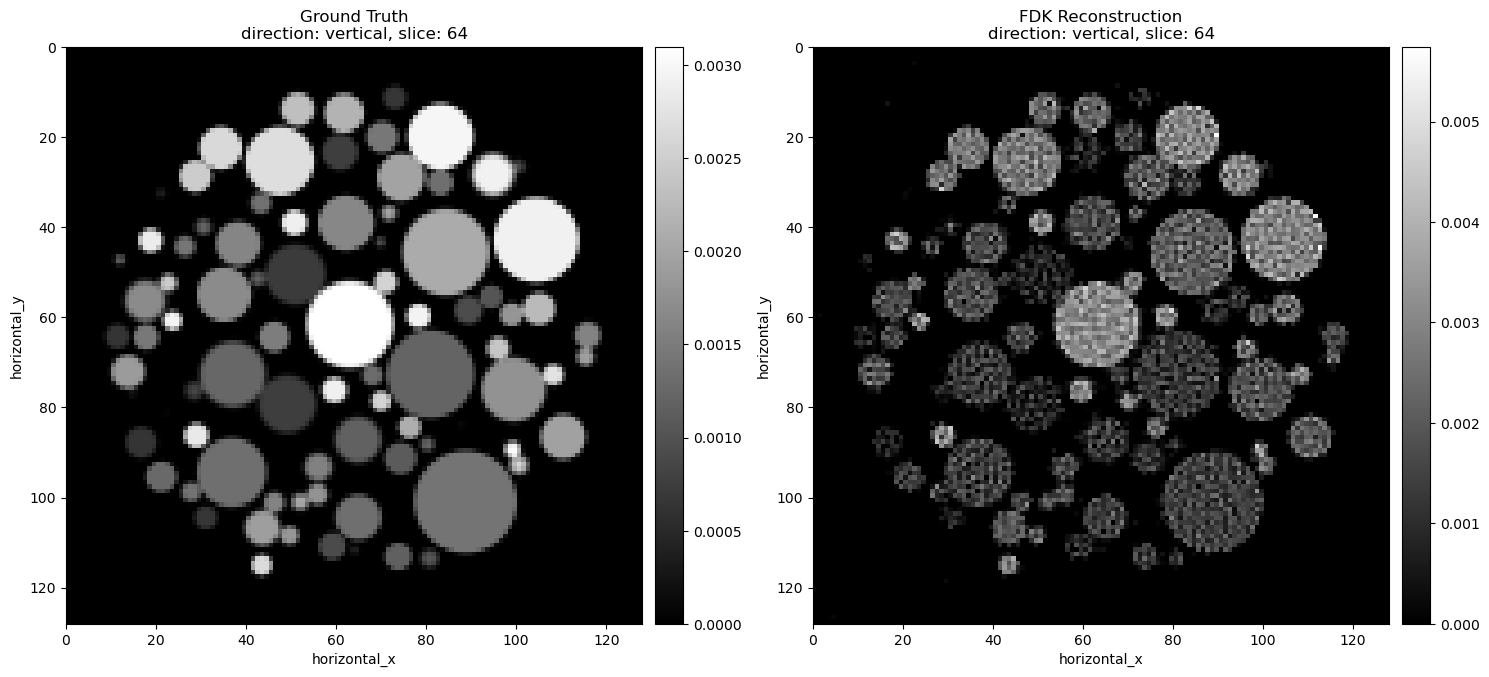

150.5036093450966
0.0


In [8]:

for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_vanilla[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()
plt.show()

show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

print( F(K.direct(pdhg_tv_explicit.solution)) )
print( G(pdhg_tv_explicit.solution) )


gamma =  1.0


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10.0


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  1000


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  10000


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  100000


  0%|          | 0/200 [00:00<?, ?it/s]

gamma =  200.0


  0%|          | 0/200 [00:00<?, ?it/s]

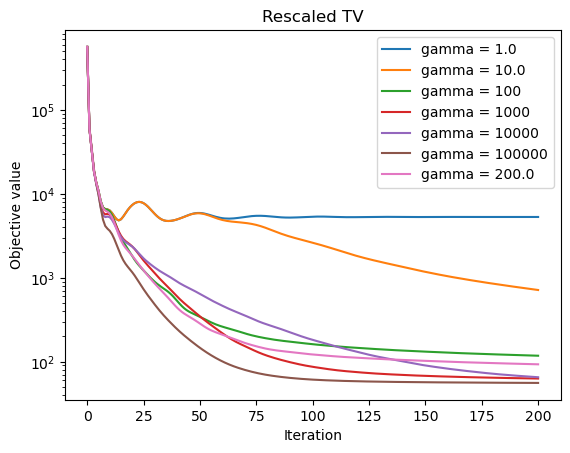

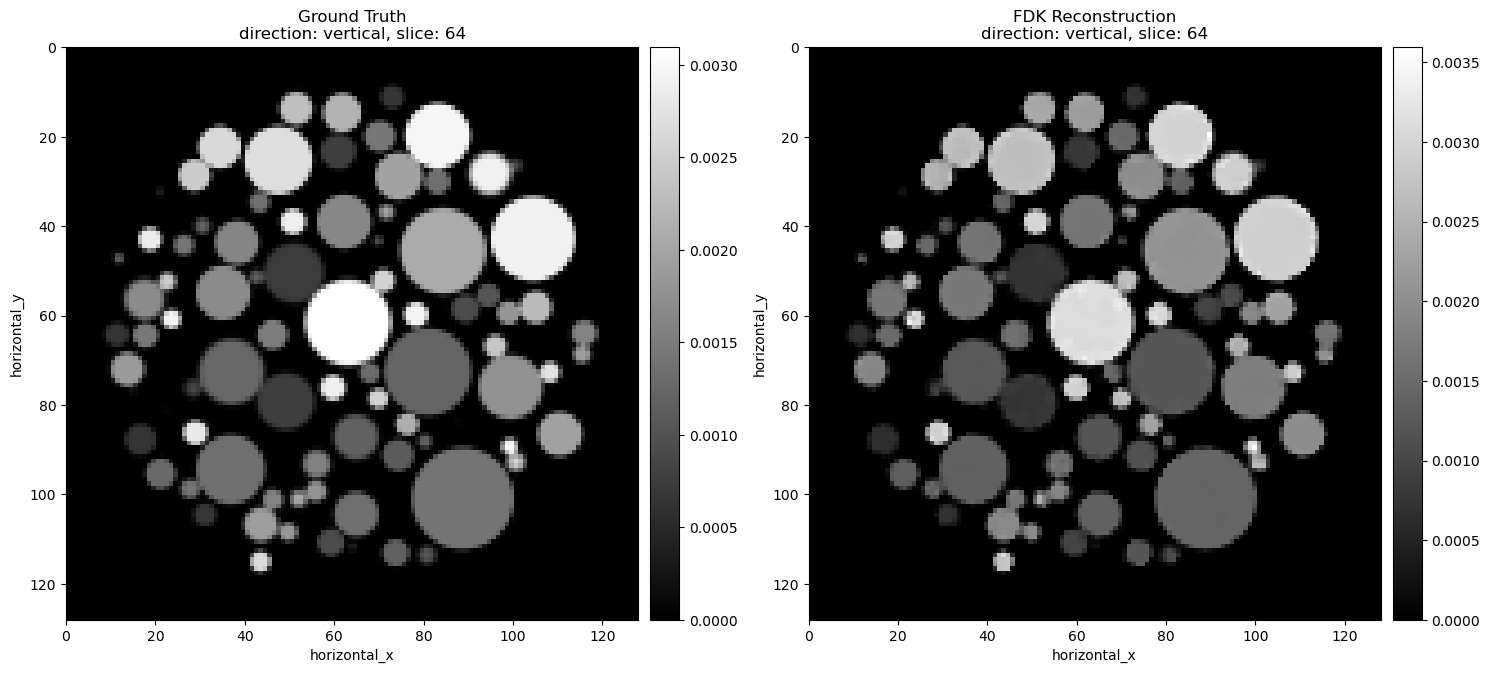

92.76982885272001
0.0


In [16]:
# Rescaled operators and functions 
alpha = 0.5
G = IndicatorBox(lower=0)
rho = 1.0
f1 = alpha * MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=absorption)
F = BlockFunction(f1, f2)

# Define BlockOperator K
Grad = GradientOperator(ig)
K_scaled = BlockOperator((1/Grad.norm())*Grad, (1/A.norm())*A)
F_scaled = ScaledArgFunction(F, [Grad.norm(),  A.norm()])


gamma_list = [0.01, 0.1, 1, 10, 100, 1000, 1/alpha]
gamma_list = [100*gamma for gamma in gamma_list]
results_scaled = []
objective_scaled = []
for gamma in gamma_list:
    print("gamma = ", gamma)
    sigma = gamma*rho
    tau =rho/gamma
    pdhg_tv_explicit = PDHG(f = F_scaled, g = G, operator = K_scaled,
                update_objective_interval = 1, check_convergence=False, sigma=sigma, tau=tau)
    pdhg_tv_explicit.run(200, verbose=1)
    results_scaled.append(pdhg_tv_explicit.solution)
    objective_scaled.append(pdhg_tv_explicit.objective)
    
    
for i, gamma in enumerate(gamma_list):
    plt.plot(range(0, 201, 1), objective_scaled[i], label='gamma = ' + str(gamma))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.title('Rescaled TV')
plt.legend()
plt.show()

show2D([ground_truth, pdhg_tv_explicit.solution], title = ['Ground Truth', 'FDK Reconstruction'], origin = 'upper', num_cols = 2);

print( F(K.direct(pdhg_tv_explicit.solution)) )
print( G(pdhg_tv_explicit.solution) )


In [23]:
K.norm()
K.get_norms_as_list()

[0.10825317547305482, 1370.426]

In [24]:
F_scaled(K_scaled.direct(pdhg_tv_explicit.solution))

5285.721945173795

In [25]:
F_scaled.proximal_conjugate(K.direct(pdhg_tv_explicit.solution), 3)

In [26]:
K.direct(pdhg_tv_explicit.solution)[1].as_array()

array([[[5.67508861e-04, 5.38254855e-04, 4.85115655e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.63539569e-04, 8.49992037e-04, 8.44153808e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.63737762e-04, 8.68435076e-04, 1.38377270e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [1.12201422e-04, 9.49009991e-05, 6.71796661e-05, ...,
         4.51627449e-04, 2.75022845e-04, 1.43890094e-04],
        [3.40816805e-05, 2.56014118e-05, 1.53619003e-05, ...,
         3.50400340e-04, 3.22922802e-04, 1.71079650e-04],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.60516244e-04, 2.86627474e-04, 2.67392257e-04]],

       [[1.94144275e-04, 3.38040525e-04, 4.48882376e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.70887937e-04, 7.62522221e-04, 8.46591138e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.34623901e-03, 

In [27]:
isinstance(Grad, BlockOperator)

False

In [1]:
Grad.norm()/A.norm()

NameError: name 'Grad' is not defined

In [29]:
A.norm()

1370.426